### (A) Finding best possible combination of metaparameters
Calculating quality function for single combination of graph vectors (one atlas, one model, one threshold). Information is stored in dictionary q having separate 2D arrays for each model. Each row of this array corresponds to certain atlas, and columns correspond to thresholds. 

In [ ]:
from identipy import beta_lin_comb
from identipy import quality_function
import numpy as np

path = 'data/graph/'
meta_atl = ['pow','har','dos','aal','mul'] 
meta_mod = ['cor','cov','par','pre']
meta_thr = [0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25]

N_thr = len(meta_thr)
q = {}
for mod in meta_mod:
    #--- store results in array for each model separately
    q[mod] = np.zeros([len(meta_atl), N_thr])
    for tup in [(atl, thr) for atl in range(len(meta_atl)) for thr in range(N_thr)]:
        print(' Model: {}, Atlas: {}, Threshold: {}'.format(mod, meta_atl[tup[0]], str(tup[1])))
        beta = [ int(x == tup[0]) for x in range(5)] + \
               [ int(mod in model) for model in meta_mod ] + \
               [ int(x == tup[1]) for x in range(N_thr)]
        q[mod][tup[0]][tup[1]] = quality_function(beta_lin_comb(path, beta)[0], beta_lin_comb(path, beta)[2], \
                                                      similarity='euclid')

#### (A1) Plotting results

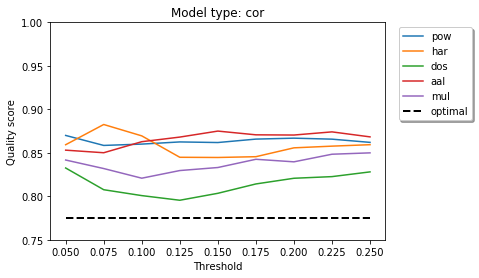

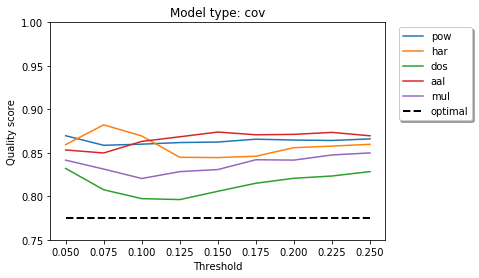

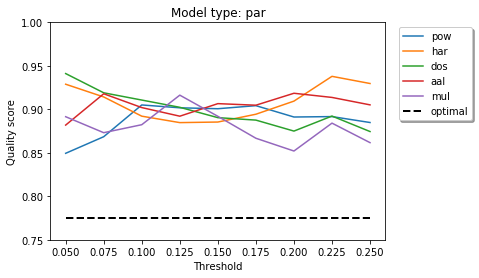

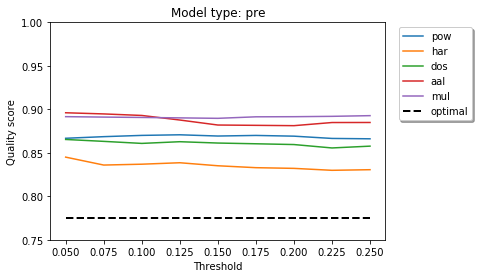

In [102]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
for mod in meta_mod:
    #--- 
    plt.plot(np.linspace(0.05,0.25,9),q[mod].T)
    if 'res' in globals():
        plt.plot(np.linspace(0.05,0.25,9), [res.fun for idx in range(9)], 'k--', linewidth=2)
    plt.xticks(np.linspace(0.05,0.25,9))
    plt.ylim((0.75,1))
    #--- cosmetic changes
    plt.title('Model type: {}'.format(mod))
    plt.xlabel('Threshold')
    plt.ylabel('Quality score')
    if 'res' in globals():
        meta_atl_leg = meta_atl; meta_atl_leg.append('optimal')
        plt.legend(meta_atl, loc='upper center', bbox_to_anchor=(1.15, 1),
                  fancybox=True, shadow=True)
    else:
        plt.legend(meta_atl, loc='upper center', bbox_to_anchor=(1.1, 1),
                  fancybox=True, shadow=True)
    plt.show()

### (B) Constrained optimization of metaparameter vector

In [43]:
from identipy import beta_lin_comb
from identipy import quality_function
from scipy.optimize import minimize
from scipy.optimize import Bounds
import numpy as np
import random
import time

path = 'data/graph/'
N_meta = 18 # number of metaparameters

#--- function to minimize
def quality_simple(beta):
    beta = list(beta)
    _, _, gv_array = beta_lin_comb(path, beta)
    return quality_function(sub_list, gv_array, similarity='euclid')

#--- initiate metaparameter vector
b0 = np.asarray([random.uniform(0,1) for idx in range(N_meta)])
sub_list, _, _ = beta_lin_comb(path, list(b0)) # get reusable sub list

#--- define constrains
bounds = Bounds([0 for inx in range (N_meta)],[1 for inx in range (N_meta)])
    
#--- MINIMIZE
res = minimize(quality_simple, b0, method='SLSQP', options={'disp': True}, bounds=bounds)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.7747882770394124
            Iterations: 76
            Function evaluations: 1520
            Gradient evaluations: 76


Function minimum value: Q = 0.7748


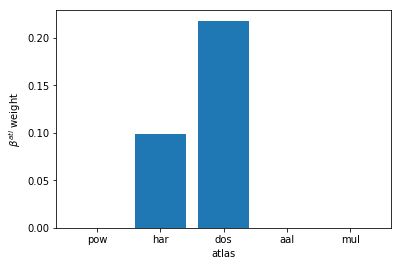

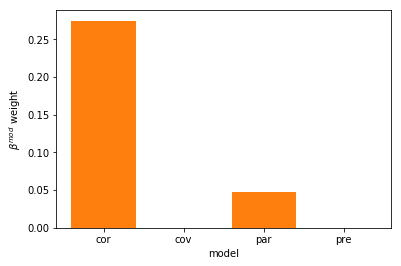

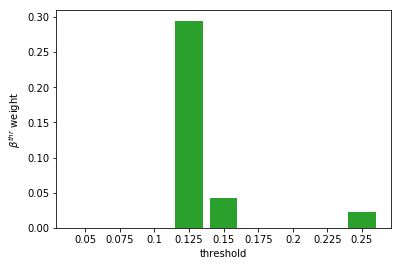

In [108]:
import matplotlib.pyplot as plt
%matplotlib inline

#--- get optimal beta vector
b_opt = res.x / np.sum(res.x) # normalize
print(f'Function minimum value: Q = {round(res.fun, 4)}')

plt.bar(meta_atl, b_opt[:5], color='C0')
plt.ylabel(r'$\beta^{atl}$ weight')
plt.xlabel('atlas')
plt.show()

plt.bar(meta_mod, b_opt[5:9], color='C1')
plt.ylabel(r'$\beta^{mod}$ weight')
plt.xlabel('model')
plt.show()

plt.bar([str(thr) for thr in meta_thr], b_opt[9:], color='C2')
plt.ylabel(r'$\beta^{thr}$ weight')
plt.xlabel('threshold')
plt.show()
